# Chapter 7 - Using gate-based Quantum Computers - Some basic quantum algorithms 
2. Phase Estimation

© 2021, 2022 Packt Publishing

Written by Alex Khan

In [1]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [3]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# to check all gate operations refer to 
# https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

In [5]:
import numpy as np

In [6]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [7]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [8]:
def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system1.1','DW_2000Q_6','Aspen-9','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [9]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [10]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [11]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, local=True, device_name='', s3_folder='', display_binary=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=1000).result()
    else:
        measured_qubits=len(circuit.qubits)
        device=set_device(device_name)
        num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        print('device', device)
        print('num reads', num_reads)
        result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        actual_simulator_cost(device, result)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [12]:
def draw_bloch(q, info=True):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")
    if info==True:
        print('Matrix:')
        print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    if info==True:
        print(' ')
        print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
        print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    #print('Bloch Sphere:')
    plt.show()
    return(q)

In [13]:
def draw_circuit(circ, info=True):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    if info==True:
        print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r, info)

In [14]:
def qft_gate(qc,qubits_needed):
    
    power=0

    for target in range(qubits_needed-1,-1,-1):
        qc.h(target)
        for control in range(target-1,-1,-1):
 
            power=target-control

            qc.cphaseshift(control, target, (np.pi/(2**(power))))


    #reverse qubits

    #for i in range (int(qubits_needed/2)):
        
        #qc.swap(i,qubits_needed-i-1)
    return(qc)

In [15]:
def qft_inv_gate(qc, qubits_needed):
    
    power=0

    for target in range(0,qubits_needed):
        
        for control in range(0,target):

            power=target-control

            qc.cphaseshift(control, target, -(np.pi/(2**(power))))
        
        qc.h(target)
    
    for i in range (int(qubits_needed/2)-1,-1,-1):
        
        qc.swap(i,qubits_needed-i-1)

    return(qc)

In [85]:
def draw_multi_qubit_phase(Qubits, Number, add_hadamard=True, draw_bloch=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        if draw_bloch:
            print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.phaseshift(0,np.pi/(2**p))
                qc.phaseshift(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        if draw_bloch:
            draw_circuit(circ, False) 
    return(qc)
        
        
    

In [93]:
def draw_multi_qubit_phase_qc(Qubits, Number, add_hadamard=True, draw_bloch=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        if draw_bloch:
            print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.rz(0,np.pi/(2**p))
                qc.rz(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        if draw_bloch:
            draw_circuit(circ, False) 
    return(qc)


In [17]:
def qc_num(num, qubits_needed):
    qubits_format='0'+str(qubits_needed)+'b'
    n_bin=format(num, qubits_format)

    qubits_needed=len(n_bin)

    qc=Circuit()
    for i in range(qubits_needed):
        if n_bin[i]=='1':
            #reverse number
            #qc.x(qubits_needed-i-1)
            qc.x(qubits_needed-i-1)


    return(qc)

In [18]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

## Storing numbers as phase information

### Introducing translation between computational and Fourier basis

In [19]:
circ=Circuit().h(0).t(0)

T  : |0|1|
          
q0 : -H-T-

T  : |0|1|

Additional result types: StateVector
Matrix:
[[0.70710678+0.j ]
 [0.5       +0.5j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [0.25] pi |1>
 


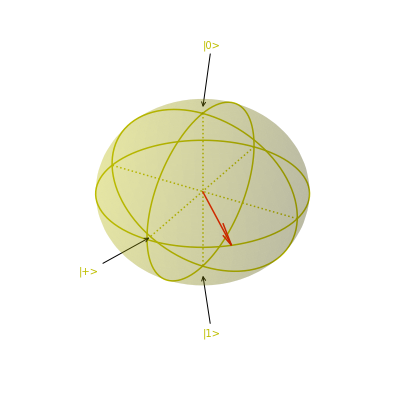

In [20]:
draw_circuit(circ)

T  : |0|1|2|
            
q0 : -H-T-H-

T  : |0|1|2|

Additional result types: StateVector
Matrix:
[[0.85355339+0.35355339j]
 [0.14644661-0.35355339j]]
 
State Vector: |psi> = sqrt( [0.85355339] ) |0> + ( sqrt( [0.14644661] )) e^i [-0.5] pi |1>
 


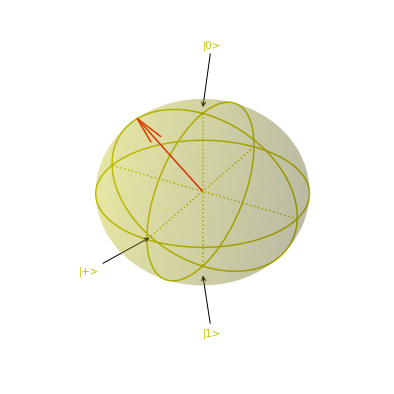

In [21]:
draw_circuit(circ.h(0))

Adding incremental phase using phaseshift

T  : |0|     1     |
                    
q0 : -H-PHASE(3.14)-

T  : |0|     1     |

Additional result types: StateVector
Matrix:
[[ 0.70710678+0.00000000e+00j]
 [-0.70710678+8.65956056e-17j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [1.] pi |1>
 


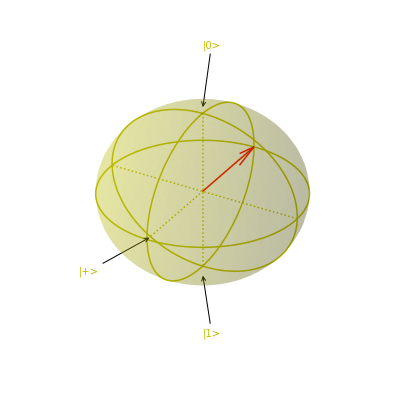

In [22]:
circ=Circuit().h(0).phaseshift(0,np.pi)
draw_circuit(circ)

T  : |0|     1     |     2     |
                                
q0 : -H-PHASE(3.14)-PHASE(1.57)-

T  : |0|     1     |     2     |

Additional result types: StateVector
Matrix:
[[ 7.07106781e-01+0.j        ]
 [-1.29893408e-16-0.70710678j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [-0.5] pi |1>
 


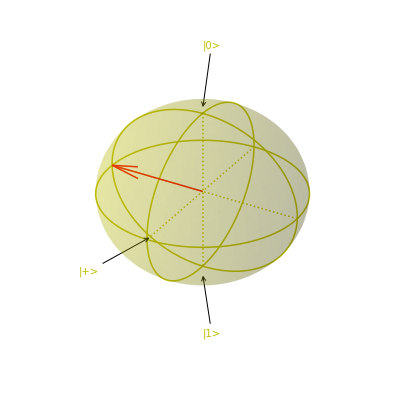

In [23]:
circ=circ.phaseshift(0,np.pi/2)
draw_circuit(circ)

T  : |0|     1     |     2     |     3      |
                                             
q0 : -H-PHASE(3.14)-PHASE(1.57)-PHASE(0.785)-

T  : |0|     1     |     2     |     3      |

Additional result types: StateVector
Matrix:
[[0.70710678+0.j ]
 [0.5       -0.5j]]
 
State Vector: |psi> = sqrt( [0.5] ) |0> + ( sqrt( [0.5] )) e^i [-0.25] pi |1>
 


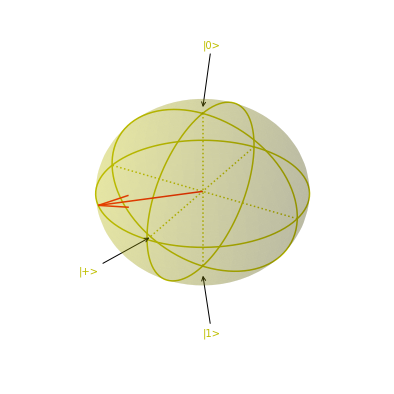

In [24]:
circ=circ.phaseshift(0,np.pi/4)
draw_circuit(circ)

## Transform a number into Phase information

Qubits: 5 Number: 3 binary: 00011
qubit 0


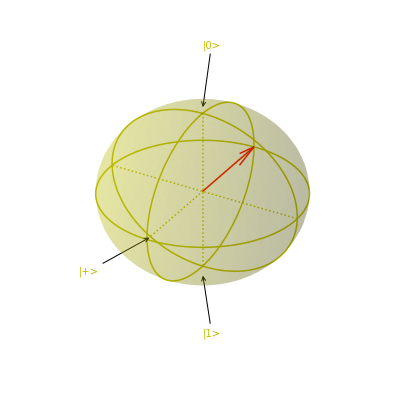

qubit 1


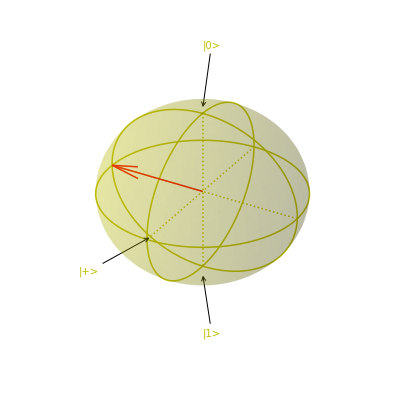

qubit 2


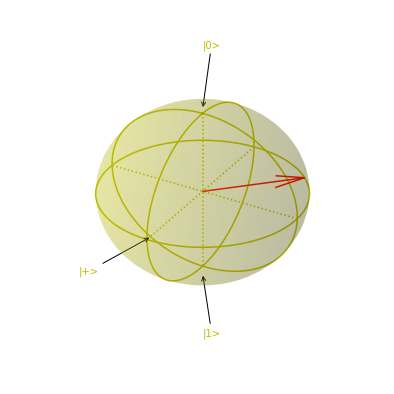

qubit 3


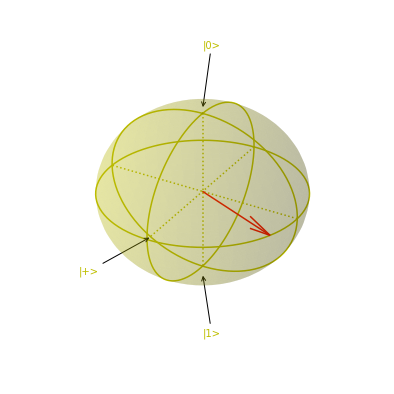

qubit 4


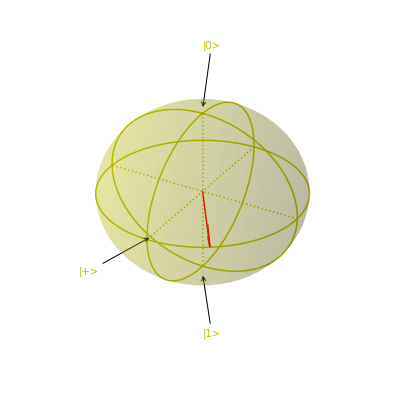

In [25]:
Qubits=5
Number=3
qc=draw_multi_qubit_phase(Qubits,Number)

In [26]:
print(qc)

T  : |0|     1      |     2      |
                                  
q0 : -H-PHASE(3.14)---------------
                                  
q1 : -H-PHASE(3.14)--PHASE(1.57)--
                                  
q2 : -H-PHASE(1.57)--PHASE(0.785)-
                                  
q3 : -H-PHASE(0.785)-PHASE(0.393)-
                                  
q4 : -H-PHASE(0.393)-PHASE(0.196)-

T  : |0|     1      |     2      |


Counter({'01010': 354, '11111': 345, '01101': 343, '01111': 333, '11101': 328, '01000': 328, '11100': 325, '10111': 323, '00011': 323, '00100': 322, '10010': 322, '10101': 321, '00001': 318, '10100': 315, '01100': 313, '00010': 313, '11001': 311, '00000': 310, '01001': 308, '11000': 308, '11011': 306, '01011': 305, '10001': 304, '11010': 301, '10000': 300, '11110': 300, '10110': 294, '00101': 292, '00110': 290, '10011': 287, '00111': 280, '01110': 278})


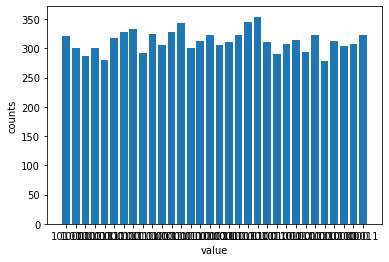

In [27]:
device = LocalSimulator()
result = device.run(qc, shots=10000).result()
counts = result.measurement_counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');

In [28]:
check_qc=qc.copy()

device = LocalSimulator()
sv_phase_circuit=check_qc.state_vector()
result = device.run(sv_phase_circuit).result()
for i in range(2**Qubits):

    print('{:+.2f}'.format(result.values[0][i]))


+0.18+0.00j
+0.15+0.10j
+0.07+0.16j
-0.03+0.17j
-0.12+0.12j
-0.17+0.03j
-0.16-0.07j
-0.10-0.15j
-0.00-0.18j
+0.10-0.15j
+0.16-0.07j
+0.17+0.03j
+0.12+0.12j
+0.03+0.17j
-0.07+0.16j
-0.15+0.10j
-0.18+0.00j
-0.15-0.10j
-0.07-0.16j
+0.03-0.17j
+0.12-0.12j
+0.17-0.03j
+0.16+0.07j
+0.10+0.15j
+0.00+0.18j
-0.10+0.15j
-0.16+0.07j
-0.17-0.03j
-0.12-0.12j
-0.03-0.17j
+0.07-0.16j
+0.15-0.10j


## Finding number out of qubit phase information

In [29]:
# Quantum Fourier Transform

In [30]:
qc_copy=qc.copy()
phase_circuit=qft_inv_gate(qc_copy,Qubits)

In [31]:
print(phase_circuit)

T  : |0|     1      |     2      |     3      |       4       |            5             |              6              |            7             |       8       |     9      | 10 | 11 |
                                                                                                                                                                                          
q0 : -H-PHASE(3.14)--H------------C--------------C--------------------------C-----------------------------C--------------------------------------------------------------------------SWAP-
                                  |              |                          |                             |                                                                          |    
q1 : -H-PHASE(3.14)--PHASE(1.57)--PHASE(-1.57)-H-|-------------C------------|---------------C-------------|--------------------------C------------------------------------------SWAP-|----
                                                 |             | 

Counter({'00011': 1000})


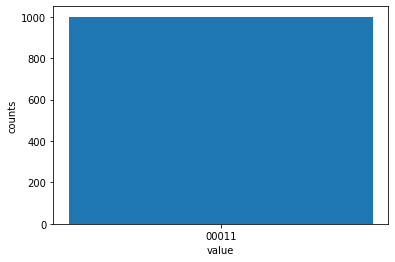

In [32]:
device = LocalSimulator()
result = device.run(phase_circuit, shots=1000).result()
counts = result.measurement_counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');

In [33]:
device = LocalSimulator()
sv_phase_circuit=phase_circuit.state_vector()
result = device.run(sv_phase_circuit).result()
for i in range(2**Qubits):

    print('{:+.2f}'.format(result.values[0][i]))


-0.00+0.00j
-0.00+0.00j
-0.00+0.00j
+1.00-0.00j
+0.00-0.00j
+0.00+0.00j
+0.00+0.00j
-0.00+0.00j
-0.00+0.00j
+0.00+0.00j
+0.00-0.00j
+0.00+0.00j
+0.00-0.00j
-0.00+0.00j
+0.00+0.00j
+0.00+0.00j
-0.00+0.00j
-0.00-0.00j
-0.00-0.00j
+0.00-0.00j
-0.00+0.00j
-0.00+0.00j
+0.00+0.00j
+0.00+0.00j
+0.00-0.00j
-0.00-0.00j
+0.00+0.00j
-0.00+0.00j
-0.00+0.00j
-0.00-0.00j
-0.00-0.00j
-0.00-0.00j


--------------end-----------------

## Compare circuits of two methods

Qubits: 3 Number: 3 binary: 011
qubit 0


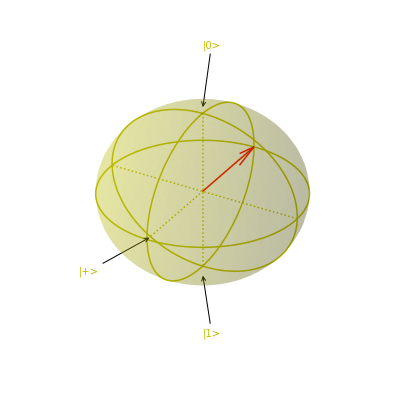

qubit 1


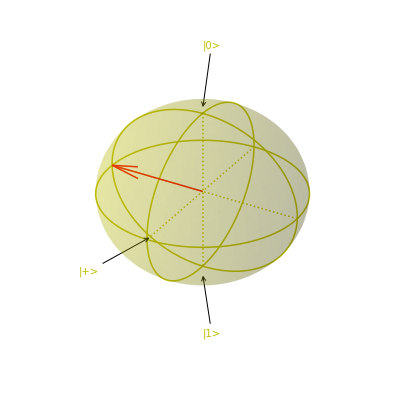

qubit 2


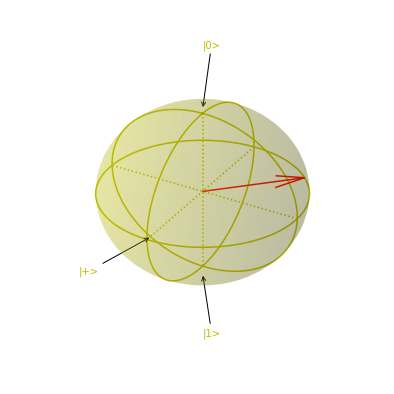

In [35]:
Qubits=3
Number=3
qc=draw_multi_qubit_phase(Qubits,Number)

Circuit from the phase adder circuit we have been using

In [36]:
print(qc)

T  : |0|     1     |     2      |
                                 
q0 : -H-PHASE(3.14)--------------
                                 
q1 : -H-PHASE(3.14)-PHASE(1.57)--
                                 
q2 : -H-PHASE(1.57)-PHASE(0.785)-

T  : |0|     1     |     2      |


Circuit from a standard QFT algorithm. This converts a number into the phase information.

In [37]:
device = LocalSimulator()
Qubits=3
num=3

qc=qc_num(num,Qubits)
qc=qft_gate(qc,Qubits)
print(qc)

T  : |0|     1     |      2       |     3     |4|
                                                 
q0 : -X-------------C--------------C-----------H-
                    |              |             
q1 : -X-C-----------|------------H-PHASE(1.57)---
        |           |                            
q2 : -H-PHASE(1.57)-PHASE(0.785)-----------------

T  : |0|     1     |      2       |     3     |4|


Notice that in the end both circuits are the same.
The phase adder implements appropriate phase rotations based on the original value of the number, 
while the QFT circuit takes the value of the number and uses control gates to implement the same 
phase rotations.

T  : |0|     1     |      2       |     3     |4|5|     6      |       7       |     8      |9| 10 |
                                                                                                    
q0 : -X-------------C--------------C-----------H-H-C--------------C----------------------------SWAP-
                    |              |               |              |                            |    
q1 : -X-C-----------|------------H-PHASE(1.57)-----PHASE(-1.57)-H-|-------------C--------------|----
        |           |                                             |             |              |    
q2 : -H-PHASE(1.57)-PHASE(0.785)----------------------------------PHASE(-0.785)-PHASE(-1.57)-H-SWAP-

T  : |0|     1     |      2       |     3     |4|5|     6      |       7       |     8      |9| 10 |
Counter({'011': 10000})


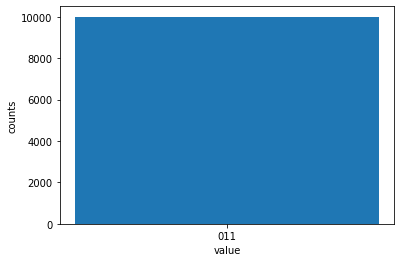

In [38]:
qc=qft_inv_gate(qc,Qubits)
print(qc)
device = LocalSimulator()
result = device.run(qc, shots=10000).result()
counts = result.measurement_counts
print(counts)
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');

----------------------- end ----------------------

## Adding numbers in phase using the phase adder

Qubits: 5 Number: 3 binary: 00011
qubit 0


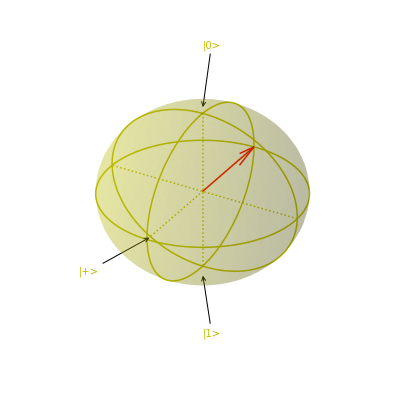

qubit 1


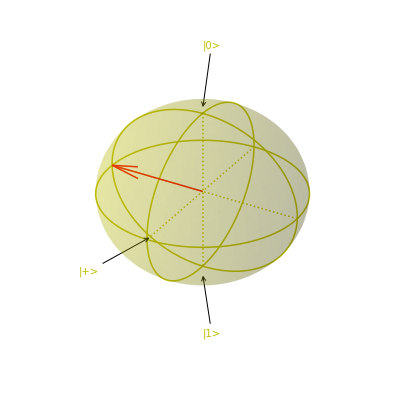

qubit 2


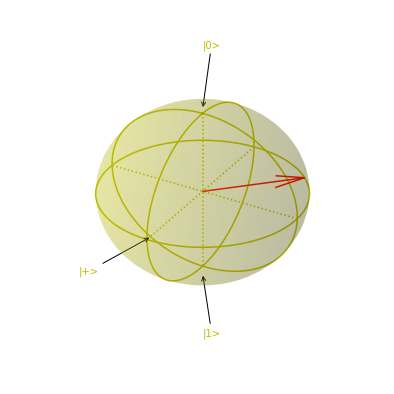

qubit 3


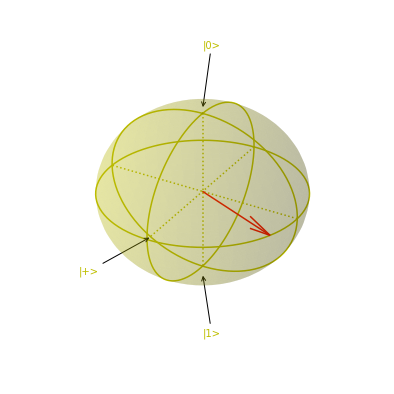

qubit 4


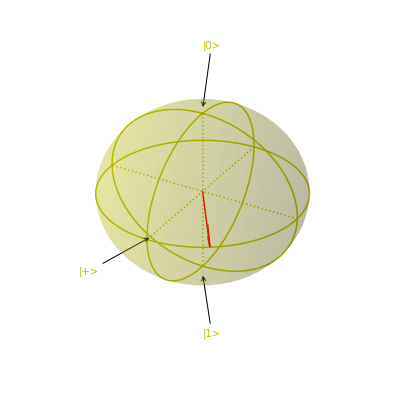

T  : |0|     1      |     2      |
                                  
q0 : -H-PHASE(3.14)---------------
                                  
q1 : -H-PHASE(3.14)--PHASE(1.57)--
                                  
q2 : -H-PHASE(1.57)--PHASE(0.785)-
                                  
q3 : -H-PHASE(0.785)-PHASE(0.393)-
                                  
q4 : -H-PHASE(0.393)-PHASE(0.196)-

T  : |0|     1      |     2      |


In [40]:
Qubits=5
Number=3
qc_3=draw_multi_qubit_phase(Qubits,Number)
print(qc_3)

Qubits: 5 Number: 5 binary: 00101
qubit 0


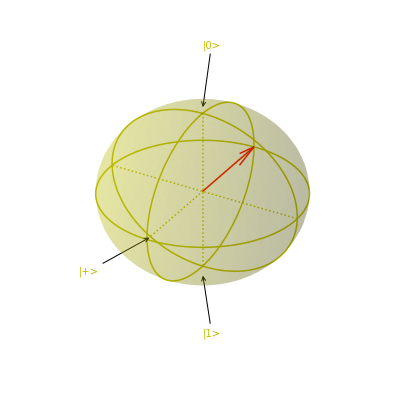

qubit 1


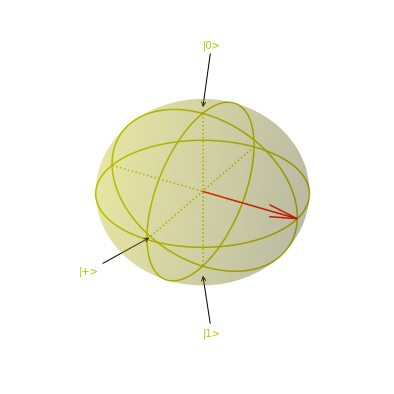

qubit 2


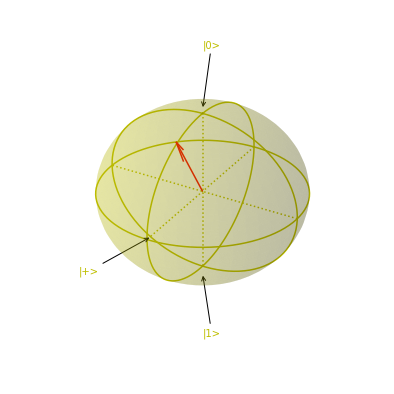

qubit 3


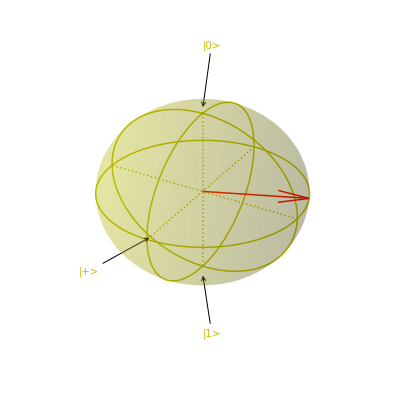

qubit 4


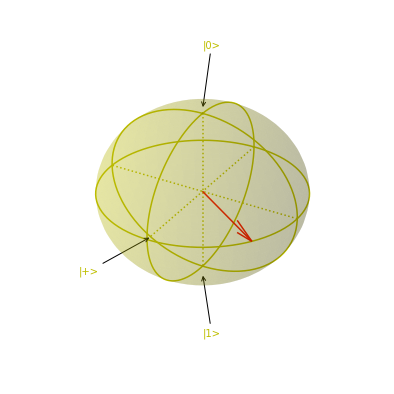

T  : |     0      |     1      |
                                
q0 : -PHASE(3.14)---------------
                                
q1 : -PHASE(1.57)---------------
                                
q2 : -PHASE(3.14)--PHASE(0.785)-
                                
q3 : -PHASE(1.57)--PHASE(0.393)-
                                
q4 : -PHASE(0.785)-PHASE(0.196)-

T  : |     0      |     1      |


In [41]:
Qubits=5
Number=5
qc_5=draw_multi_qubit_phase(Qubits,Number,False)
print(qc_5)

In [42]:
qc_total=qc_3.add(qc_5)
print(qc_total)

T  : |0|     1      |     2      |     3      |     4      |
                                                            
q0 : -H-PHASE(3.14)--PHASE(3.14)----------------------------
                                                            
q1 : -H-PHASE(3.14)--PHASE(1.57)--PHASE(1.57)---------------
                                                            
q2 : -H-PHASE(1.57)--PHASE(0.785)-PHASE(3.14)--PHASE(0.785)-
                                                            
q3 : -H-PHASE(0.785)-PHASE(0.393)-PHASE(1.57)--PHASE(0.393)-
                                                            
q4 : -H-PHASE(0.393)-PHASE(0.196)-PHASE(0.785)-PHASE(0.196)-

T  : |0|     1      |     2      |     3      |     4      |


In [43]:
phase_circuit=qft_inv_gate(qc_total,5)

In [44]:
print(phase_circuit)

T  : |0|     1      |     2      |     3      |     4      |       5       |            6             |              7              |            8             |       9       |     10     | 11 | 12 |
                                                                                                                                                                                                       
q0 : -H-PHASE(3.14)--PHASE(3.14)--H------------C--------------C--------------------------C-----------------------------C--------------------------------------------------------------------------SWAP-
                                               |              |                          |                             |                                                                          |    
q1 : -H-PHASE(3.14)--PHASE(1.57)--PHASE(1.57)--PHASE(-1.57)-H-|-------------C------------|---------------C-------------|--------------------------C------------------------------------------SWAP-|----


Counter({'01000': 1000})


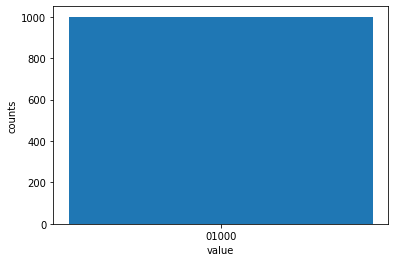

In [45]:
device = LocalSimulator()
result = device.run(phase_circuit, shots=1000).result()
counts = result.measurement_counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');

Qubits: 5 Number: 8 binary: 01000
qubit 0


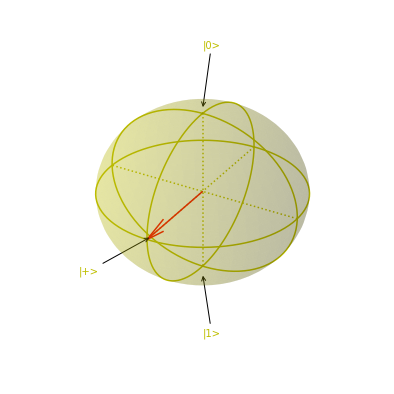

qubit 1


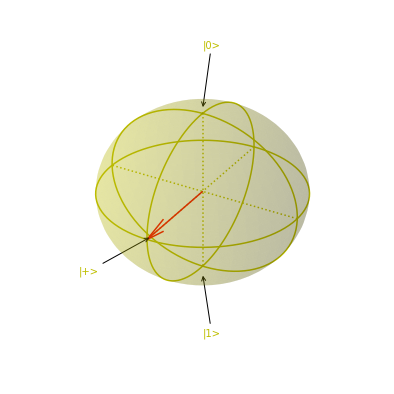

qubit 2


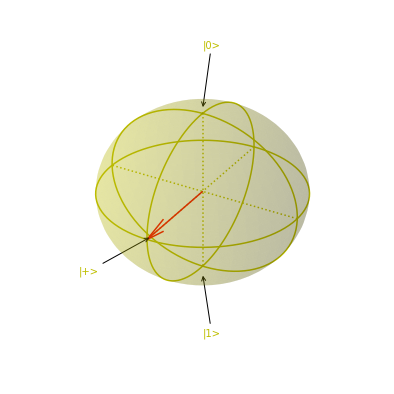

qubit 3


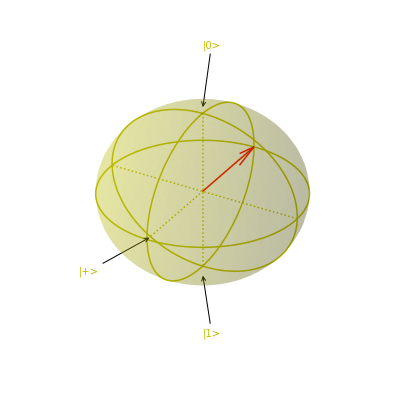

qubit 4


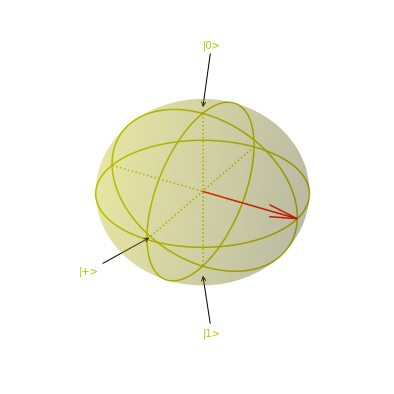

T  : |0|     1     |
                    
q0 : -H-------------
                    
q1 : -H-------------
                    
q2 : -H-------------
                    
q3 : -H-PHASE(3.14)-
                    
q4 : -H-PHASE(1.57)-

T  : |0|     1     |


In [46]:
Qubits=5
Number=8
qc_8=draw_multi_qubit_phase(Qubits,Number)
print(qc_8)

In [47]:
qc_copy=qc_8.copy()
phase_circuit=qft_inv_gate(qc_copy,Qubits)

Counter({'01000': 1000})


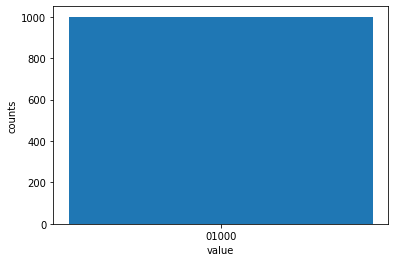

In [48]:
device = LocalSimulator()
result = device.run(phase_circuit, shots=1000).result()
counts = result.measurement_counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');

----------------- end -------------------------

## Revealing the number from phase information using a quantum device

Qubits: 11 Number: 1234 binary: 10011010010
Qubits: 11 Number: 765 binary: 01011111101
Counter({'11111001111': 1000})
value counts
1999 1000


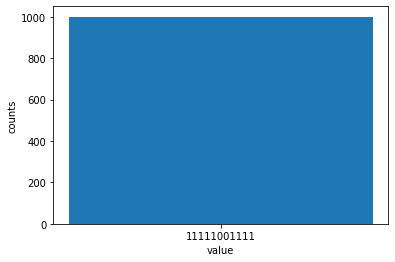

In [90]:
Qubits=11
qc_a=draw_multi_qubit_phase(Qubits,1234, True, False)
qc_b=draw_multi_qubit_phase(Qubits,765,False, False)
qc_total=qc_a.add(qc_b)
full_circuit=qft_inv_gate(qc_total,Qubits)
device = LocalSimulator()
result = device.run(full_circuit, shots=1000).result()
counts = result.measurement_counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');
print('value counts')
for i,j in zip(counts.keys(),counts.values()):

    if j>10:
        print(int('0b'+str(i),2),j)


In [98]:
Qubits=49
# max number 1,125,899,906,842,624
qc_a=draw_multi_qubit_phase(Qubits,100000000000000, True, False)
qc_b=draw_multi_qubit_phase(Qubits,100000000000001,False, False)
qc_total=qc_a.add(qc_b)
full_circuit=qft_inv_gate(qc_total,Qubits)

Qubits: 49 Number: 100000000000000 binary: 0010110101111001100010000011110100100000000000000
Qubits: 49 Number: 100000000000001 binary: 0010110101111001100010000011110100100000000000001


Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
max shots: 1000
for 49 measured qubits the maximum allowed shots: 1,000
simulator cost per  minute : $ 0.275
total cost cannot be estimated
device Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1)
num reads 1000
simulator cost per  minute : $ 0.275
total execution time:  232322 ms
total cost estimated: $ 1.0648091666666666
{200000000000001: 1000}


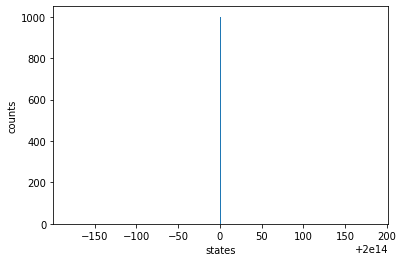

In [99]:
result=run_circuit(full_circuit, False, 'TN1', s3_folder, display_binary=False)

Counter({'0101101011110011000100000111101001000000000000001': 1000})
value counts
200000000000001 1000


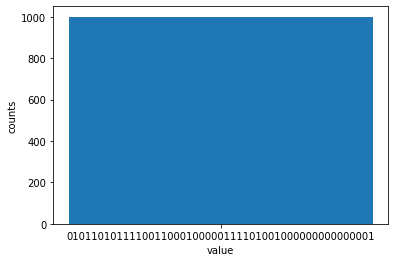

In [102]:
counts = result.measurement_counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('value');
plt.ylabel('counts');
print('value counts')
for i,j in zip(counts.keys(),counts.values()):

    if j>0:
        print(int('0b'+str(i),2),j)
